In [1]:
from __future__ import print_function
import numpy as np
import scipy.io as sio
import pandas as pd
from sklearn.metrics import mean_squared_error

np.random.seed(1337)  # for reproducibility

# from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [25]:
# input image dimensions
img_rows, img_cols = 128, 128
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)

# Training data, shuffled and split
WB = np.array(sio.loadmat('sandstone_data.mat')['Data'])
Y_data = np.array(sio.loadmat('sandstone_data.mat')['L'])
Y_data = (Y_data-min(Y_data))/(max(Y_data)-min(Y_data))
X_data = np.reshape(WB,(768,1,img_rows,img_cols))

# Add 380 generated images using VAE+ST from Ruijin's code
WB_gen = np.array(sio.loadmat('generate_sandstone_data.mat')['Data'])
Y_gen = np.array(sio.loadmat('generate_sandstone_data.mat')['L'])
Y_gen = (Y_gen-min(Y_gen))/(max(Y_gen)-min(Y_gen))
X_gen = np.transpose(np.reshape(WB_gen,(380,1,img_rows,img_cols)),[0,1,3,2])


#Define Traing data and validation data
X_train = np.concatenate((X_data[0:700], X_gen[0:300]), axis=0);
Y_train = np.concatenate((Y_data[0:700], Y_gen[0:300]), axis=0);
X_val = np.concatenate((X_data[700:768], X_gen[300:380]), axis=0);
Y_val = np.concatenate((Y_data[700:768], Y_gen[300:380]), axis=0);

"""
X_train = X_data[:720]
Y_train = Y_data[:720]

X_val = X_data[720:]
Y_val = Y_data[720:]
"""

WB1 = sio.loadmat('test_sandstone_data.mat')['Data']
X_test = np.reshape(WB1, (240, 1, img_rows, img_cols))
Y_test = sio.loadmat('test_sandstone_data.mat')['L']
Y_test = (Y_test-min(Y_test))/(max(Y_test) - min(Y_test))


if K.image_dim_ordering() == 'th':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_val = X_val.reshape(X_val.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    

X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_val.shape[0], 'validate samples')
print(X_test.shape[0], 'test samples')

X_train shape: (1000, 128, 128, 1)
1000 train samples
148 validate samples
240 test samples


In [78]:
# CNN

model = Sequential()

model.add(Convolution2D(24, (6, 6), padding='same', input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
# model.add(Dropout(0.25))

model.add(Convolution2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
# model.add(Dropout(0.25))


model.add(Convolution2D(48, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
# model.add(Dropout(0.25))


model.add(Convolution2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.25))


model.add(Convolution2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.25))


#Training result was worse with this layer...complex network led to overfitting...need to fine tune the framework
model.add(Convolution2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.25))


"""
model.add(Convolution2D(128, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
# model.add(Dropout(0.25))


model.add(Convolution2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
# model.add(Dropout(0.25))
"""


model.add(Flatten())
# model.add(Dense(1000))
# model.add(Activation('relu'))
# model.add(Dropout(0.25))
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(1))
model.add(Activation('linear'))

model.compile(loss='mse', optimizer='adam', metrics=['mse'])

In [79]:
model.fit(X_train, Y_train, batch_size=40, epochs=120, verbose=1, validation_data=(X_val, Y_val))

Train on 1000 samples, validate on 148 samples
Epoch 1/120
1000/1000 [==============================] - 19s - loss: 0.0446 - mean_squared_error: 0.0446 - val_loss: 0.0125 - val_mean_squared_error: 0.0125
Epoch 2/120
1000/1000 [==============================] - 18s - loss: 0.0140 - mean_squared_error: 0.0140 - val_loss: 0.0149 - val_mean_squared_error: 0.0149
Epoch 3/120
1000/1000 [==============================] - 18s - loss: 0.0106 - mean_squared_error: 0.0106 - val_loss: 0.0088 - val_mean_squared_error: 0.0088
Epoch 4/120
1000/1000 [==============================] - 18s - loss: 0.0106 - mean_squared_error: 0.0106 - val_loss: 0.0223 - val_mean_squared_error: 0.0223
Epoch 5/120
1000/1000 [==============================] - 18s - loss: 0.0105 - mean_squared_error: 0.0105 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 6/120
1000/1000 [==============================] - 18s - loss: 0.0088 - mean_squared_error: 0.0088 - val_loss: 0.0179 - val_mean_squared_error: 0.0179
Epoch 7/120

1000/1000 [==============================] - 17s - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 53/120
1000/1000 [==============================] - 18s - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0056 - val_mean_squared_error: 0.0056
Epoch 54/120
1000/1000 [==============================] - 18s - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 55/120
1000/1000 [==============================] - 17s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 56/120
1000/1000 [==============================] - 18s - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0096 - val_mean_squared_error: 0.0096
Epoch 57/120
1000/1000 [==============================] - 18s - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 58/120
1000/1000 [==============================] - 18s - l

1000/1000 [==============================] - 18s - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 104/120
1000/1000 [==============================] - 17s - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 105/120
1000/1000 [==============================] - 17s - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 106/120
1000/1000 [==============================] - 18s - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 107/120
1000/1000 [==============================] - 18s - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 108/120
1000/1000 [==============================] - 17s - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 109/120
1000/1000 [==============================] - 1

0.000524100670715


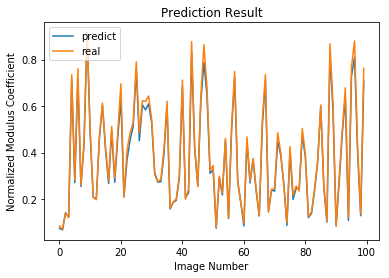

In [80]:
x=[]
for i in range(100):
    x.append(i)

pred=model.predict(X_train)
print(mean_squared_error(Y_train, pred))

fig1 = plt.figure()
ax1=fig1.add_subplot(1,1,1)

ax1.plot(x,pred[0:100], label='predict')
ax1.plot(x,Y_train[0:100],label='real')
plt.legend()
ax1.set_title('Prediction Result')
ax1.set_xlabel('Image Number')
ax1.set_ylabel('Normalized Modulus Coefficient')

0.0321682237403


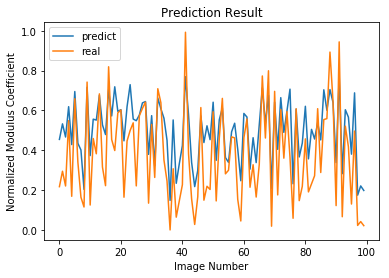

In [81]:
x=[]
for i in range(100):
    x.append(i)

pred=model.predict(X_test)
print(mean_squared_error(Y_test, pred))

fig1 = plt.figure()
ax1=fig1.add_subplot(1,1,1)

ax1.plot(x,pred[0:100], label='predict')
ax1.plot(x,Y_test[0:100],label='real')
plt.legend()
ax1.set_title('Prediction Result')
ax1.set_xlabel('Image Number')
ax1.set_ylabel('Normalized Modulus Coefficient')